<a href="https://colab.research.google.com/github/vincentsun870530/Soen490/blob/iteration6_li/project/data_analytics/360_python/Time_series_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2019 The TensorFlow Authors. 
##### Ref: https://www.tensorflow.org/tutorials/structured_data/time_series

# Install nvidia tool to test GPU

In [1]:
# from google.colab import files

# uploaded = files.upload()

# for fn in uploaded.keys():
#   print('User uploaded file "{name}" with length {length} bytes'.format(
#       name=fn, length=len(uploaded[fn])))

# Time series forecasting

In [33]:
from __future__ import absolute_import, division, print_function, unicode_literals
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import io

In [3]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

## The traffic intersection dataset
This traffic count dataset uses a Moscow intersection (https://www.youtube.com/watch?v=yXXrz1vITNM) recorded by the ???.

This dataset contains 

In [4]:
df = pd.read_csv(csv_path)
#df = pd.read_csv(io.StringIO(uploaded['generatedDataset.csv'].decode('utf-8')))

Let's take a glance at the data.

In [5]:
df.head(10)

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3
5,01.01.2009 01:00:00,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
6,01.01.2009 01:10:00,996.50,-7.62,265.81,-8.30,94.8,3.44,3.26,0.18,2.04,3.27,1305.68,0.18,0.63,166.5
7,01.01.2009 01:20:00,996.50,-7.62,265.81,-8.36,94.4,3.44,3.25,0.19,2.03,3.26,1305.69,0.19,0.50,118.6
8,01.01.2009 01:30:00,996.50,-7.91,265.52,-8.73,93.8,3.36,3.15,0.21,1.97,3.16,1307.17,0.28,0.75,188.5
9,01.01.2009 01:40:00,996.53,-8.43,264.99,-9.34,93.1,3.23,3.00,0.22,1.88,3.02,1309.85,0.59,0.88,185.0


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f990d62b2b0>],
      dtype=object)

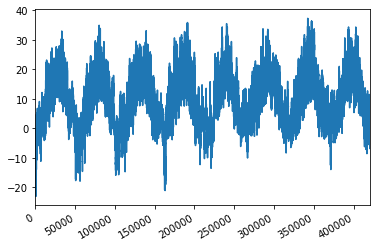

In [6]:
df['T (degC)'].plot(subplots=True)

As you can see above,

The function below returns the above described windows of time for the model to train on. The parameter `history_size` is the size of the past window of information. The `target_size` is how far in the future does the model need to learn to predict. The `target_size` is the label that needs to be predicted.

In [7]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

The first 8,000 rows of the data will be the training dataset, and there remaining will be the validation dataset.

In [8]:
TRAIN_SPLIT = 300000

Setting seed to ensure reproducibility.

In [9]:
#tf.random.set_seed(13)

First, we will train a model using only a single feature (6:00-7:00am), and use it to make predictions for that value in the future.

In [11]:
uni_data = (df['T (degC)']+25).apply(np.floor)
uni_data.index = df['Date Time']
uni_data.head(10)

Date Time
01.01.2009 00:10:00    16.0
01.01.2009 00:20:00    16.0
01.01.2009 00:30:00    16.0
01.01.2009 00:40:00    16.0
01.01.2009 00:50:00    16.0
01.01.2009 01:00:00    16.0
01.01.2009 01:10:00    17.0
01.01.2009 01:20:00    17.0
01.01.2009 01:30:00    17.0
01.01.2009 01:40:00    16.0
Name: T (degC), dtype: float64

Let's observe how this data looks across time.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f990d135fd0>],
      dtype=object)

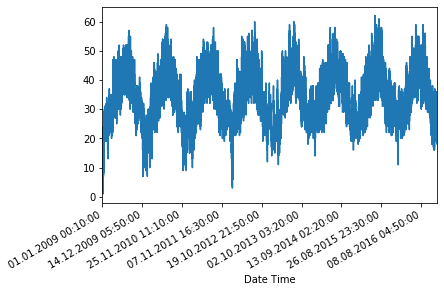

In [12]:
uni_data.plot(subplots=True)

In [13]:
uni_data = uni_data.values
uni_data.size

420551

It is important to scale features before training a neural network. Standardization is a common way of doing this scaling by subtracting the mean and dividing by the standard deviation of each feature.You could also use a `tf.keras.utils.normalize` method that rescales the values into a range of [0,1].

Note: The mean and standard deviation should only be computed using the training data.

In [14]:
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()

Let's standardize the data.

In [15]:
uni_data = (uni_data-uni_train_mean)/uni_train_std
#uni_data = tf.keras.utils.normalize(uni_data,axis=1)
uni_data

array([-2.05261953, -2.05261953, -2.05261953, ..., -1.47403536,
       -1.58975219, -1.58975219])

Let's now create the data for the univariate model. For part 1, the model will be given the last 20 recorded temperature observations, and needs to learn to predict the temperature at the next time step. 

In [16]:
univariate_past_history = 20
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

In [17]:
y_val_uni[0]

0.6088676508060731

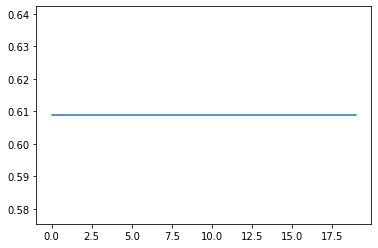

In [18]:
plt.plot(x_val_uni[1])
plt.show()

In [19]:
x_train_uni
#x_train_uni.shape

array([[[-2.05261953],
        [-2.05261953],
        [-2.05261953],
        ...,
        [-2.05261953],
        [-2.05261953],
        [-2.05261953]],

       [[-2.05261953],
        [-2.05261953],
        [-2.05261953],
        ...,
        [-2.05261953],
        [-2.05261953],
        [-2.05261953]],

       [[-2.05261953],
        [-2.05261953],
        [-2.05261953],
        ...,
        [-2.05261953],
        [-2.05261953],
        [-2.05261953]],

       ...,

       [[ 0.72458448],
        [ 0.72458448],
        [ 0.72458448],
        ...,
        [ 0.60886765],
        [ 0.60886765],
        [ 0.60886765]],

       [[ 0.72458448],
        [ 0.72458448],
        [ 0.72458448],
        ...,
        [ 0.60886765],
        [ 0.60886765],
        [ 0.60886765]],

       [[ 0.72458448],
        [ 0.72458448],
        [ 0.72458448],
        ...,
        [ 0.60886765],
        [ 0.60886765],
        [ 0.60886765]]])

In [20]:
y_train_uni
#y_train_uni.shape

array([-2.05261953, -2.05261953, -2.05261953, ...,  0.60886765,
        0.60886765,  0.60886765])

This is what the `univariate_data` function returns.

In [21]:
print ('Single window of past history')
print (x_train_uni[3])
print ('\n Target temperature to predict')
print (y_train_uni[3])

Single window of past history
[[-2.05261953]
 [-2.05261953]
 [-2.05261953]
 [-1.9369027 ]
 [-1.9369027 ]
 [-1.9369027 ]
 [-2.05261953]
 [-2.05261953]
 [-2.05261953]
 [-2.05261953]
 [-2.05261953]
 [-2.05261953]
 [-2.05261953]
 [-2.05261953]
 [-2.05261953]
 [-2.05261953]
 [-2.05261953]
 [-2.05261953]
 [-2.05261953]
 [-2.05261953]]

 Target temperature to predict
-2.1683363634857016


Now that the data has been created, let's take a look at a single example. The information given to the network is given in blue, and it must predict the value at the red cross.

In [22]:
def create_time_steps(length):
  time_steps = []
  for i in range(-length, 0, 1):
    time_steps.append(i)
  return time_steps

In [23]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

<module 'matplotlib.pyplot' from '/home/lisun/.local/lib/python3.6/site-packages/matplotlib/pyplot.py'>

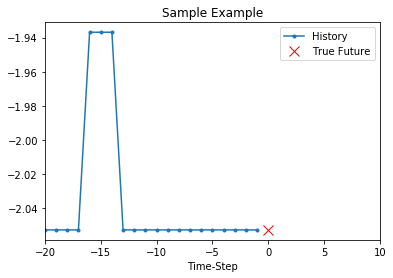

In [24]:
show_plot([x_train_uni[2], y_train_uni[2]], 0, 'Sample Example')

### Baseline
Before proceeding to train a model, let's first set a simple baseline. Given an input point, the baseline method looks at all the history and predicts the next point to be the average of the last 60 observations.

In [25]:
def baseline(history):
  return np.mean(history)

<module 'matplotlib.pyplot' from '/home/lisun/.local/lib/python3.6/site-packages/matplotlib/pyplot.py'>

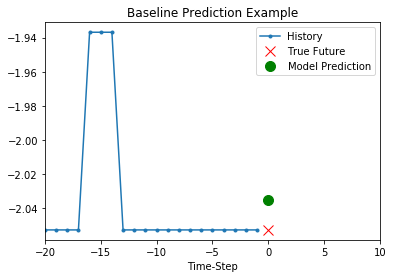

In [26]:
show_plot([x_train_uni[2], y_train_uni[2], baseline(x_train_uni[2])], 0,
           'Baseline Prediction Example')

Let's see if you can beat this baseline using a recurrent neural network.

### Recurrent neural network

A Recurrent Neural Network (RNN) is a type of neural network well-suited to time series data. RNNs process a time series step-by-step, maintaining an internal state summarizing the information they've seen so far. For more details, read the [RNN tutorial](https://www.tensorflow.org/tutorials/sequences/recurrent). In this tutorial, you will use a specialized RNN layer called Long Short Term Memory ([LSTM](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/layers/LSTM))

Let's now use `tf.data` to shuffle, batch, and cache the dataset.

In [27]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

The following visualisation should help you understand how the data is represented after batching.

![Time Series](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/time_series.png?raw=1)

You will see the LSTM requires the input shape of the data it is being given.

In [28]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(1, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Let's make a sample prediction, to check the output of the model. 

In [30]:
#for x, y in val_univariate.take(1):
#    print(simple_lstm_model.predict(x).shape)

Let's train the model now. Due to the large size of the dataset, in the interest of saving time, each epoch will only run for 200 steps, instead of the complete training data as normally done.

In [31]:
EVALUATION_INTERVAL = 200
EPOCHS = 50

simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/50
200/200 [==============================] - 4s 18ms/step - loss: 0.7825 - val_loss: 0.4788
Epoch 2/50
200/200 [==============================] - 3s 14ms/step - loss: 0.6473 - val_loss: 0.3113
Epoch 3/50
200/200 [==============================] - 3s 14ms/step - loss: 0.4202 - val_loss: 0.2051
Epoch 4/50
200/200 [==============================] - 3s 14ms/step - loss: 0.3221 - val_loss: 0.1407
Epoch 5/50
200/200 [==============================] - 3s 14ms/step - loss: 0.2562 - val_loss: 0.0928
Epoch 6/50
200/200 [==============================] - 3s 14ms/step - loss: 0.1594 - val_loss: 0.0774
Epoch 7/50
200/200 [==============================] - 3s 14ms/step - loss: 0.1761 - val_loss: 0.0522
Epoch 8/50
200/200 [==============================] - 3s 14ms/step - loss: 0.1370 - val_loss: 0.0442
Epoch 9/50
200/200 [==============================] - 3s 14ms/step - loss: 0.0943 - val_loss: 0.03

#### Predict using the simple LSTM model
Now that you have trained your simple LSTM, let's try and make a few predictions.

In [34]:
for x, y in val_univariate.take(80):
  plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
  plot.show()

AttributeError: 'Tensor' object has no attribute 'numpy'

In [35]:
for x, y in val_univariate.take(100):
  print(simple_lstm_model.predict(x)[0])

ValueError: When using data tensors as input to a model, you should specify the `steps` argument.

This looks better than the baseline. Now that you have seen the basics, let's move on to part two, where you will work with a multivariate time series.